In [25]:
from utils import harris, dist2, find_sift
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import numpy as np
from PIL import Image 
# add your imports below
import cv2
import random

## 1. Load images and Convert to grayscale

In [26]:
img1 = Image.open('uttower_left.jpg').convert('L')
img1c = np.array(img1, dtype = np.float32) 

img2 = Image.open('uttower_right.jpg').convert('L')
img2c = np.array(img2, dtype = np.float32)

img1c /= 255.0
img2c /= 255.0


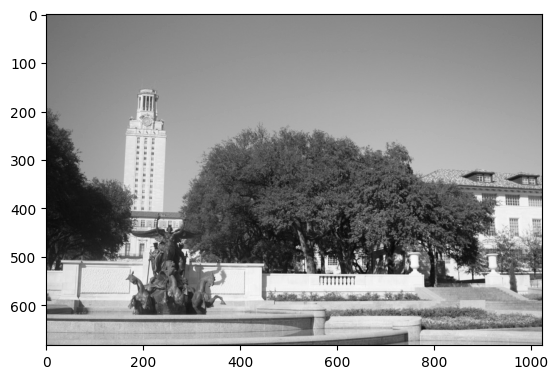

In [27]:
plt.imshow(img1c, cmap='gray')

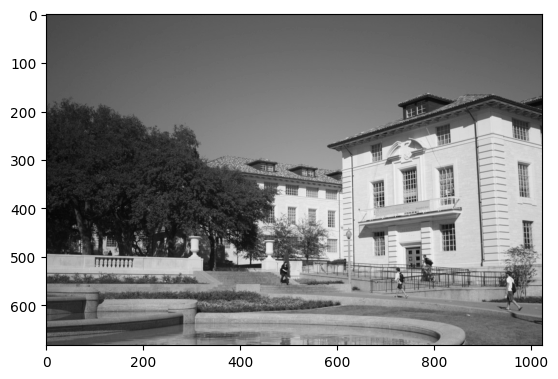

In [28]:
plt.imshow(img2c, cmap='gray')

## 2. Detect Feature Points

In [29]:
radius = 5
thresh = 0.08
cim1, r1, c1 = harris(img1c, 2, thresh, radius)
cim2, r2, c2 = harris(img2c, 2, thresh, radius) 

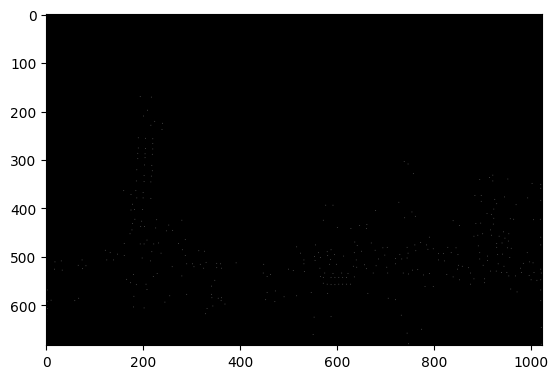

In [30]:
plt.imshow(cim1, cmap='gray')

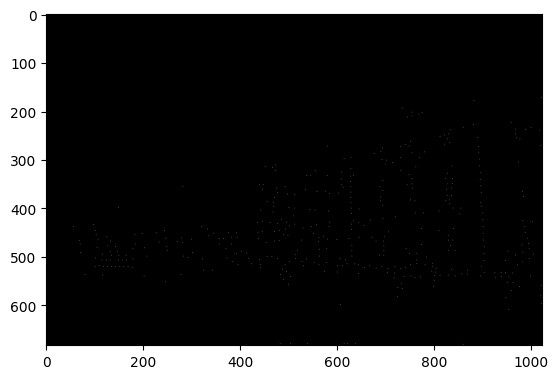

In [31]:
plt.imshow(cim2, cmap='gray')

In [32]:
def draw_corners(img, r, c):
    img_copy = img.copy()
    fig, ax = plt.subplots(figsize = (10, 10))
    for i in range(0, len(r)):
        rect = patches.Rectangle((c[i], r[i]), 10, 10, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img_copy, cmap='gray')

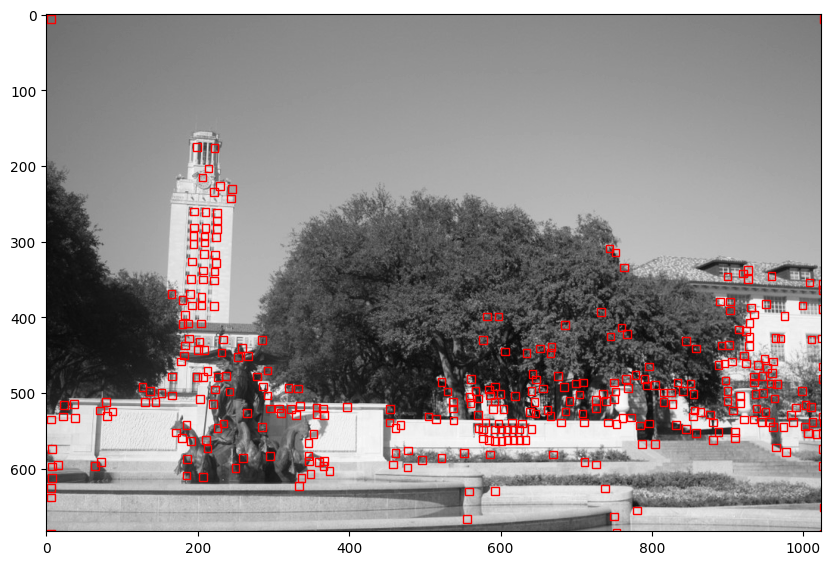

In [33]:
draw_corners(img1, r1, c1)

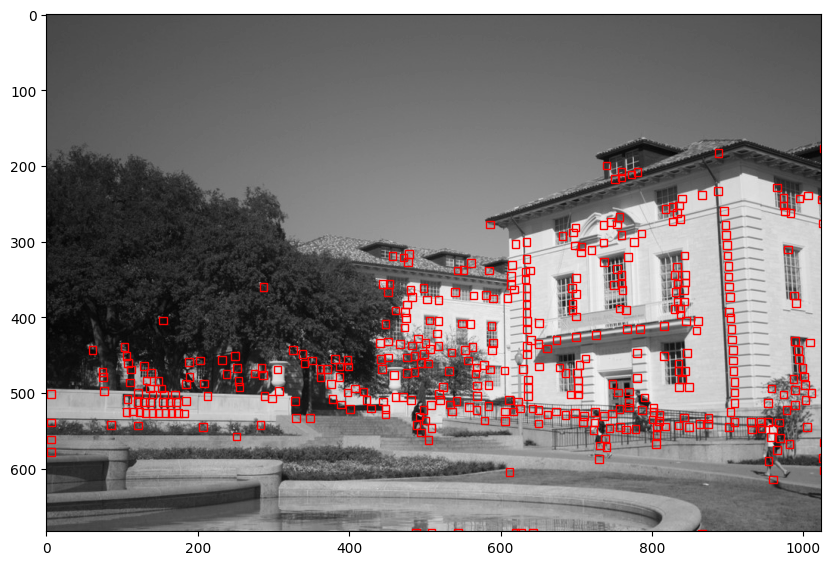

In [34]:
draw_corners(img2, r2, c2)

## 3. Extract local neighborhoods around every keypoint

In [35]:
#def neighbor_descriptors(img, r, c, width):
    #radius = int((width - 1) / 2)
    #final_descriptor = np.zeros((len(r), width * width), dtype=np.float32)
    #patch = np.zeros((width, width), dtype=np.float32)
    #img_pad = np.pad(img, radius, mode='constant', constant_values= 0)
    
    #for i in range(len(r)):
        #srow = max(0, r[i] - radius)
        #erow = min(img_pad.shape[0], r[i] + radius + 1)
        #scol = max(0, c[i] - radius)
        #ecol = min(img_pad.shape[1], c[i] + radius + 1)
        #patch = img_pad[srow:erow, scol:ecol]
        #if patch.shape != (width, width):
            #patch = np.pad(patch, ((0, width - patch.shape[0]), (0, width - patch.shape[1])), mode='constant', constant_values=0)
        
        #pf = patch.flatten()
        #final_descriptor[i] = pf

    #return final_descriptor


In [36]:
def sift_d(img, r, c, w):
    d = find_sift(img, np.array([(c[i], r[i], w) for i in range(len(r))]))
    return d

In [37]:
#if using neighbor descriptors
#radius = 5
#descriptors_1 = neighbor_descriptors(img1c, r1, c1, radius)
#descriptors_2 = neighbor_descriptors(img2c, r1, c1, radius)
#print (descriptors_1.shape)
#print (descriptors_2.shape)

descriptors_1 = sift_d(img1c, r1, c1, 5)
descriptors_2 = sift_d(img2c, r2, c2, 5)
print (descriptors_1.shape)
print (descriptors_2.shape)


(356, 128)
(424, 128)


## 4. Compute distances between descriptors

In [38]:
# use dist2 from utils.py to compute dist between descriptors
distances = dist2(descriptors_2, descriptors_1)
print(distances.shape)

(356, 424)


## 5. Select Matches

In [39]:
def filter_descriptors_by_dist(distances, thresh):
    matches = np.argwhere(distances < thresh)
    return matches

filtered_matches = filter_descriptors_by_dist(distances, 0.2)
print(filtered_matches.shape)
valid_indices = np.logical_and(filtered_matches[:, 0] < descriptors_1.shape[0], filtered_matches[:, 1] < descriptors_1.shape[0])
filtered_matches = filtered_matches[valid_indices]
print(filtered_matches.shape)

(184, 2)
(176, 2)


## 6. RANSAC

In [40]:
def draw_inliers(img1, img2, r1, c1, r2, c2, inliers):
    img1_copy = img1.copy()
    img2_copy = img2.copy()

    fig, ax = plt.subplots(figsize=(12, 6))


    ax.imshow(np.hstack((img1_copy, img2_copy)), cmap='gray')

    img2_offset = img1.shape[1]

    for i in inliers:
        i1 = i[0]
        i2 = i[1]
        rect1 = patches.Rectangle((c1[i1], r1[i1]), 10, 10, linewidth=1, edgecolor='g', facecolor='none')
        rect2 = patches.Rectangle((c2[i2] + img2_offset, r2[i2]), 10, 10, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect1)
        ax.add_patch(rect2)
        ax.plot([c1[i1], c2[i2] + img2_offset], [r1[i1], r2[i2]], '-r')

    plt.show()


In [41]:
def RANSAC(filtered_matches, eps, num_loops):
    max_inliers = []
    bestH = None
    best_residual = np.inf

    for i in range(num_loops):
        A = []
        inliers = []
        dist = []
        indices = np.random.choice(len(filtered_matches), size=4, replace=False)

        for j in indices:
            x1 = c1[filtered_matches[j][0]]
            y1 = r1[filtered_matches[j][0]]
            x2 = c2[filtered_matches[j][1]]
            y2 = r2[filtered_matches[j][1]]
            A.append([[x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1, -x2], [0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1, -y2]])

        A = np.array(A).reshape(-1, 9)
        _, _, vh = np.linalg.svd(A, full_matrices=True)
        H = vh[-1].reshape(3, 3)
        H /= H[2, 2]

        for p in range(len(filtered_matches)):
            x1 = c1[filtered_matches[p][0]]
            y1 = r1[filtered_matches[p][0]]
            x2 = c2[filtered_matches[p][1]]
            y2 = r2[filtered_matches[p][1]]
            projected = np.dot(H, np.array([x1, y1, 1]))
            if projected[2] != 0:
                projected /= projected[2]
            else:
                continue  # Skip if projection is invalid

            distance = np.linalg.norm(np.array([x2, y2]) - projected[:2])

            if distance < eps:
                inliers.append(filtered_matches[p])
                dist.append(distance)

        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            bestH = H
            best_residual = np.mean(dist)

    return max_inliers, best_residual, bestH


number of inliers: 96
residual: 3.2485347340821424
[[ 1.08038377e+00 -1.06808523e-01 -4.48528283e+02]
 [ 9.86941210e-02  9.36295030e-01 -5.76588991e+01]
 [ 1.46781495e-04 -1.45304695e-04  1.00000000e+00]]


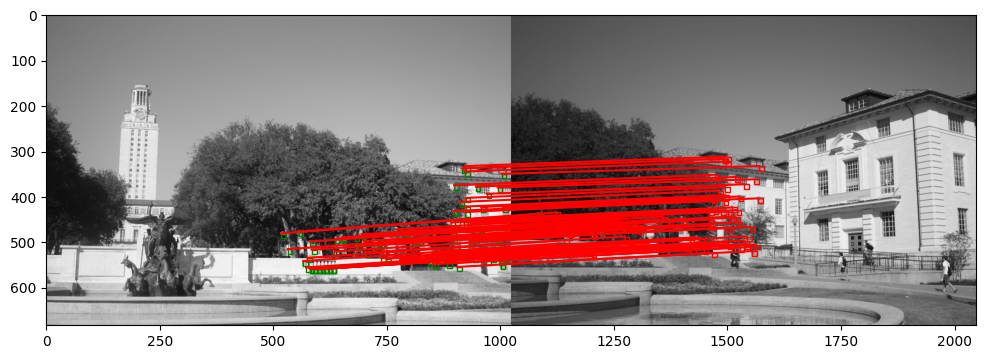

In [42]:
# report num of inliers and the average residual for the inliers
inliers, residual, H = RANSAC(filtered_matches, 10, 1000)
print("number of inliers: " + str(len(inliers)))
print("residual: " + str(residual))
print(H)

inliers_formatted = [[inlier[0], inlier[1]] for inlier in inliers]
finliers = np.array(inliers_formatted)
draw_inliers(img1c,img2c, r1, c1, r2, c2, inliers_formatted)


## 7. Warp one image onto the other

In [43]:
def warp_img(image_left, H):
    # this part of code is referenced from Ajinkya Tejankar
    # get the height and width of the image
    # this function will work with color images
    # so, having third color channel is not a problem
    h_left, w_left = image_left.shape[:2]

    # we want to find where the image corners are going to land
    # so, we create a matrix of four corner points
    C_left = np.array([
        [0, 0     , w_left, w_left],
        [0, h_left, 0     , h_left],
        [1, 1     , 1     , 1     ]
    ])

    # apply the homography to the corner points to get projected corner points
    Cp_left = H @ C_left
    Cp_left = Cp_left / Cp_left[-1, :]

    # find the minimum height and width of the projected corners
    w_min, h_min = Cp_left[:-1].min(axis=1).tolist()
    # we might need to properly floor or ceil the floats to prevent
    # the edge pixels from getting cropped but this works for our needs
    # feel free to fix this
    w_min, h_min = int(np.abs(w_min)), int(np.abs(h_min))
    # what's the final warped image size that can hold the full image?
    warped_image_shape = (h_left + h_min, w_left + w_min)

    # we create a new homography that applies the translation
    # that would be otherwise cropped by the warp function below
    Ht = np.array([
        [1, 0, w_min],
        [0, 1, h_min],
        [0, 0, 1    ]
    ])
    # apply the translation homography so that the image is warped
    # but does not have a negative translation relative to origin
    Hw = Ht @ H
    # may not be strictly necessary but make sure that (3,3) is 1
    Hw = Hw / Hw[-1, -1]

    # use skimage.transform.ProjectiveTransform to create a transform for the homography Hw
    tform = skimage.transform.ProjectiveTransform(Hw)
    # use skimage.transform.warp to apply the transform
    warped_image = skimage.transform.warp(image_left, tform.inverse, output_shape = warped_image_shape)

    return warped_image

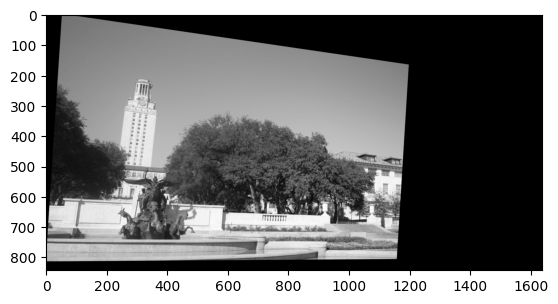

In [44]:
#I had to use a fixed homography to see the results of 7 and 8
H = ([[ 1.27430545e+00, -7.59977796e-02, -5.61317507e+02],
       [ 1.64746487e-01,  1.19150852e+00, -1.60587398e+02],
       [ 2.66754677e-04, -3.55768597e-06,  1.00000000e+00]])


warped_img1 = warp_img(img1c, H)
plt.imshow(warped_img1, cmap='gray')

## 8. Create a new image to hold the panorama

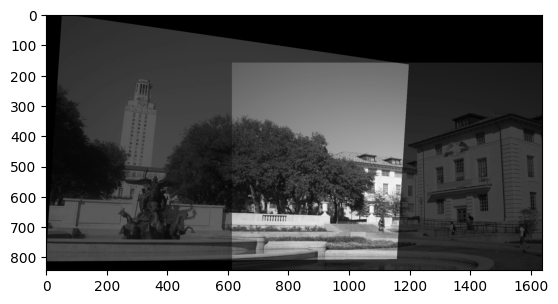

In [45]:
def create_panorama(warped_img1, img2):
    im1 = warped_img1/3
    width = im1.shape[1]
    height = im1.shape[0]

    # Calculate the offsets for placing images
    offset_x = width - img2.shape[1]
    offset_y = height - img2.shape[0]
    
    for i in range(offset_y, height):
        for j in range(offset_x, width):
            if im1[i, j] == 0:
                im1[i, j] = img2[i - offset_y, j - offset_x]/ 4   
            elif im1[i, j] > 0 and img2[i - offset_y, j - offset_x] > 0:
                im1[i, j] = (im1[i, j] + img2[i - offset_y, j - offset_x]) /1.5 
                    
    return im1

panorama_gray = create_panorama(warped_img1, img2c)
plt.imshow(panorama_gray, cmap='gray')

In [46]:
def create_panorama_rgb(warped_img1, img2, H):
    im1 = warped_img1
    warped_img1 = warp_img(im1, H)/3
    width = warped_img1.shape[1]
    height = warped_img1.shape[0]

    # Calculate the offsets for placing images
    offset_x = width - img2.shape[1]
    offset_y = height - img2.shape[0]

    # Loop through each pixel position in img2 and modify warped_img1
    for i in range(offset_y, height):
        for j in range(offset_x, width):
            for c in range(3):
                if warped_img1[i, j, c] == 0:
                    warped_img1[i, j, c] = img2[i - offset_y, j - offset_x, c] /2
                elif warped_img1[i, j, c] > 0 and img2[i - offset_y, j - offset_x, c] > 0:
                    warped_img1[i, j, c] = (warped_img1[i, j, c] + img2[i - offset_y, j - offset_x, c]) / 1.2
                    
    warped_img1 = np.clip(warped_img1, 0, 1)
    return warped_img1


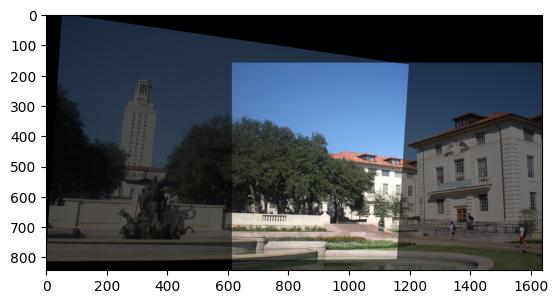

In [47]:
img3 = Image.open('uttower_left.jpg')
img3c = np.asarray(img3)/255 

img4 = Image.open('uttower_right.jpg')
img4c = np.asarray(img4)/255 


#print(img3c.shape)
#print(img4c.shape)
panorama = create_panorama_rgb(img3c, img4c, H)
plt.imshow(panorama)

